In [2]:
## Provide a wider display for easier viewing
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# HW1 - MSBA6420 - DM

In [3]:
## import the libraries needed
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler

## 4.  A predictive model has been applied to a test data set and has classified 87 records as fradulent (31 correctly so) and 953 as non-fradulent (919 correctly so).

# <b>Present the confusion matrix for this scenario.</b>

In [4]:
## Just using some dummy data to create a matrix - I will replace the values below
data = {'predict': [1 , 1, 0, 1],
       'actual': [1, 0, 0, 1]
       }

df = pd.DataFrame(data, columns = ['predict', 'actual'])

confusion_mat = pd.crosstab(df['predict'], df['actual'], rownames = ['Predicted'], colnames = ['Actual'])

### Replace the values with the correct ones based on the question
confusion_mat[0][0] = 31
confusion_mat[0][1] = 56
confusion_mat[1][0] = 34
confusion_mat[1][1] = 919
confusion_mat.rename(index = {0: 'fradulent', 1: 'non-fradulent'}, 
                     columns = {0: 'fradulent', 1: 'non-fradulent'}, inplace = True)
## Print the confusion matrix (transposed)
confusion_mat.T

Predicted,fradulent,non-fradulent
Actual,,
fradulent,31,56
non-fradulent,34,919


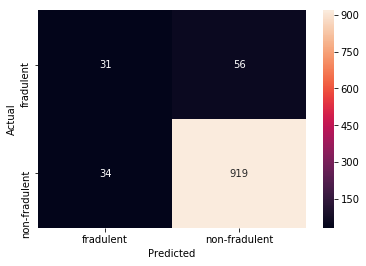

In [5]:
## Show a heatmap of the confusion matrix
sns.heatmap(confusion_mat.T, annot=True, fmt = 'g')
plt.show()


# <b>Calculate the error rate and accuracy rate.<b>

In [6]:
accuracy = (31+919) / (31+919+34+56)
print("Accuracy rate is: {}".format(accuracy))

Accuracy rate is: 0.9134615384615384


In [7]:
error = 1 - accuracy
print("Error rate: {}".format(error))

Error rate: 0.08653846153846156


# <b>Calculate precision, recall, f-measure for each of two outcome classes - fraudulent and non-fraudulent records.</b>

In [8]:
# precision - fraudulent
p_fraud = 31 / (31 + 34)
# recall - fraudulent
r_fraud = 31 / (31 + 56)
# f-measure - fraudulent
f_fraud = 1 / (.5 * (1/p_fraud + 1/r_fraud))
# precision - non-fraudulent
p_nonfraud = 919 / (919 + 56)
# recall - non-fraudulent
r_nonfraud = 919 / (919 + 34)
# f-measure - non-fraudulent
f_nonfraud = 1 / (.5 * (1/p_nonfraud + 1/r_nonfraud))

print("Precision for fraudulent class: {}\n\
Recall for fraudulent class: {}\n\
F-measure for fraudulent class: {}\n\n\
Precision for non-fraudulent class: {}\n\
Recall for non-fraudulent class: {}\n\
F-measure for non-fraudulent class: {}".format(p_fraud, r_fraud, f_fraud, p_nonfraud, r_nonfraud, f_nonfraud))

Precision for fraudulent class: 0.47692307692307695
Recall for fraudulent class: 0.3563218390804598
F-measure for fraudulent class: 0.4078947368421053

Precision for non-fraudulent class: 0.9425641025641026
Recall for non-fraudulent class: 0.9643231899265478
F-measure for non-fraudulent class: 0.9533195020746889


# <b>Calculate the accuracy rate that would be achieved by naïve (majority) rule on this data.</b>

In [9]:
## Using majority rule, we classify them all as belonging to the 919 number, which is the non-fradulent class.
print("Accuracy rate using naïve (majority rule) is: {}".format((919)/(31+919+34+56)))

Accuracy rate using naïve (majority rule) is: 0.8836538461538461


# 5.
Use classification techniques on the *Breast Cancer* dataset.

Specifically, build a decision tree, logistic regression and k-nearest neighbors that predicts the diagnose
result based on ten real-valued features (mean, standard error, and "worst" or largest of these features).
Explore how well different model perform for several different parameter values. When is overfitting and
when is underfitting? Show how you set the model that provides the best predictive performance.

Present a brief overview of your predictive modeling process, explorations, and discuss your results. Make
sure you present information about the model “goodness” (possible things to think about: confusion matrix,
predictive accuracy, classification error, precision, recall, f-measure).

In [10]:
## Create label columns for our data set since they don't come in with labels
features = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave_points",
           "symmetry", "fractal_dimension"]

## start with the first two column names, id and diagnosis
colnames = ["id", "diagnosis"]

## For each feature, we have the mean, standard error, and worst of each observation
## so we have to add each of these labels
for item in features:
    colnames.append("mean_" + item)
for item in features:
    colnames.append(item + "_se")
for item in features:
    colnames.append("worst_" + item)

In [11]:
## Read in our data set using pandas, and give the appropriate column names
wdbc = pd.read_csv("wdbc.data", header = None, names = colnames)

In [12]:
## What are our classes?  What are we trying to predict?
print(wdbc.diagnosis.unique())
print()
print("Two types of diagnoses - B = benign, M = malignant")

['M' 'B']

Two types of diagnoses - B = benign, M = malignant


In [13]:
## What are their splits?  How many of each?
## Just checking to see if the data set is skewed one way or the other - looks like a 2/3 split which should be ok
total_obvs = wdbc.groupby("diagnosis")["id"].count().sum()
total_benign = wdbc.groupby("diagnosis")["id"].count()[0]
total_malignant = wdbc.groupby("diagnosis")["id"].count()[1]

print("{} total benign observations, \
      {} % of overall observations".format(total_benign, round(total_benign/total_obvs*100, 2)))
print("{} total malignant observations, \
      {} % of overall observations".format(total_malignant, round(total_malignant/total_obvs*100, 2)))

357 total benign observations,       62.74 % of overall observations
212 total malignant observations,       37.26 % of overall observations


In [14]:
# create our target variable - make it binary since right now it is categorical - we will need this for the classifiers down below
wdbc["target"] = np.where(wdbc["diagnosis"] == 'M', 1, 0)

## look at our data, to get a sense of what is included - 
## we have a lot of parameters to work with, we will likely only need a few - more observations may lead to more noise.
wdbc.head()

,id,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


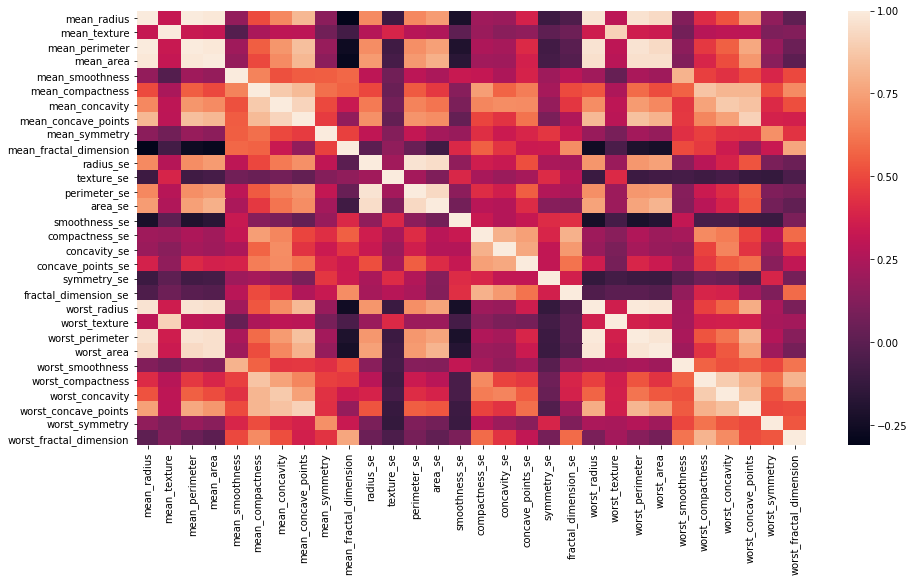

In [15]:
## Build a correlation matrix - to observe what features are correlated with each other
## If features are tied together, it may skew the models, especially Logistic Regression and kNN
wdbc_corr = wdbc.iloc[:, 2:-1].corr()

plt.figure(2, figsize=(15, 8))
sns.heatmap(wdbc_corr, xticklabels = wdbc_corr.columns, yticklabels=wdbc_corr.columns)
plt.show()

# Definitely some correlation between the variables - later on we will normalize the data for the Logistic Regression model

In [16]:
## Grabbing all the features for the Decision Tree - I will prune them later on
X = wdbc.iloc[:, 2:-1]
## Define my target variable - which I created a little bit ago
y = wdbc["target"]

## Create splits of the data to starting training models below, 70/30
## Random seed of 42 so that I can reproduce these results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [17]:
## I make all of my data into numpy arrays - so they can be used in the machine learning models

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

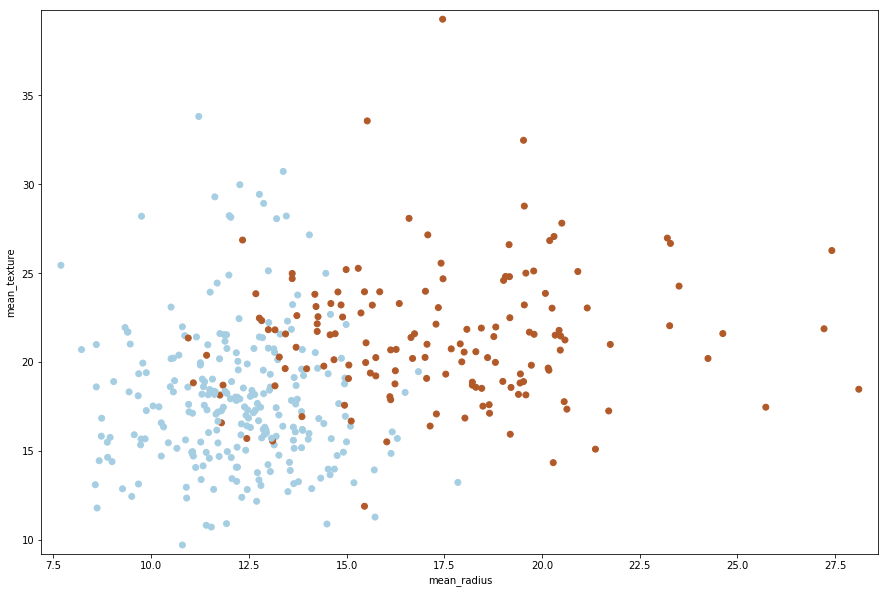

In [18]:
## Take a look at the distribution of the training points and see how they are distributed
from mpl_toolkits.mplot3d import Axes3D

## We'll just use the first two features for the visualization
X = X_train[:, [0, 1]]
Y = y_train

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

## Create a big figure so we can see 
plt.figure(2, figsize=(15, 10))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
plt.xlabel('mean_radius')
plt.ylabel('mean_texture')

## Set the limits based on the min/max values for the features we're demoing
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

# A. DecisionTree Model

## First thing to do is to determine what the best params for the DT model by running GridSearch and doing different model simulations using various hyperparameter settings.  This is called *hyperparameter tuning*.

In [19]:
## Create a new DecisionTree Classifier
dt = tree.DecisionTreeClassifier()

## Let's test for different criteria in our model so we can tune this before running it
## on the full data
param_grid = {"criterion": ["gini", "entropy"],
             "splitter": ["best", "random"],
             "max_depth": range(1, 15),
             "random_state": [42]
             }

## Use gridsearch to test all versions of the model, with 1000 fits.
dt_gscv = GridSearchCV(dt, param_grid, cv = 10)

## fit model to our training data
dt_gscv.fit(X_train, y_train)

C:\Python\envs\MSBA2020\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 15), 'random_state': [42],
  

In [20]:
## Get our best params and their scores
print(dt_gscv.best_params_)
print()

## Print out how well it performed using the best params
print(dt_gscv.best_score_)

## save our best params so we can use them in our actual DT model!
best_dt_params = dt_gscv.best_params_

{'criterion': 'gini', 'max_depth': 7, 'random_state': 42, 'splitter': 'random'}

0.9447236180904522


In [21]:
# We start with initializing our DecisionTree classifier with the best params based on our GridSearch. 
clf = tree.DecisionTreeClassifier(**best_dt_params)

## Train the model (fit the data)
# 'fit' builds a decision tree from the training set (X, y).
clf = clf.fit(X_train, y_train)

In [22]:
## Evaluate performance by cross-validation
scores = cross_val_score(clf, X_train, y_train, cv = 10)
print(scores)

# The mean score and the 95% confidence interval of our scores:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.925      0.95       0.9        0.95       0.975      0.9
 0.975      0.95       0.975      0.94736842]
Accuracy: 0.94 (+/- 0.05)


In [23]:
## Build a confusion matrix from our Decision Tree model - we want to see how accurate it is
#from sklearn.metrics import confusion_matrix

## Try to predict the outcomes on our test data
predicted = clf.predict(X_test)

## Compare that with our ACTUAL values from the test data set
matrix = confusion_matrix(y_test, predicted)
print(matrix)
print()

## Create a report to show our precision(accuracy), recall, and f1 for predictions
report = classification_report(y_test, predicted)
print(report)

[[102   6]
 [  5  58]]

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       108
           1       0.91      0.92      0.91        63

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



# The model correctly identifies 95% (102/108) of the benign cells, but only predicts the malignant tumors accurately 91%(58/63) of the time - not a great outcome and could potentially be very costly during a real diagnosis.  I want to visualie the DT boundaries to see how it is identifying each cell.

# Now we can plot the Decision Tree boundaries and see how the model would  make its selections, using the first two features of the data.

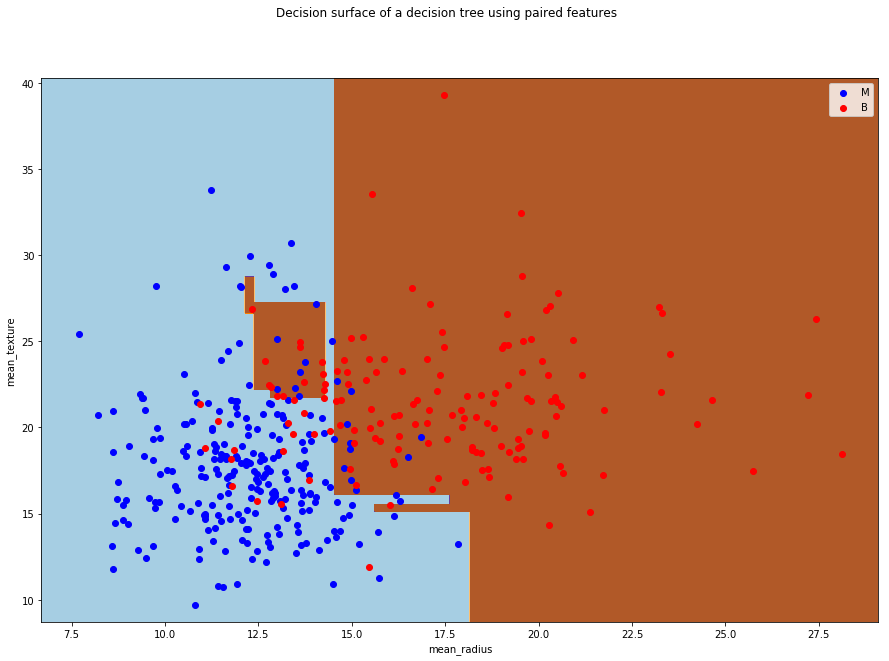

In [24]:
## Grab the feature names from the original df to display in the plot below
feature_names = wdbc.columns[2:-1]

## Create a variable for the target names
target_names = np.array(wdbc.diagnosis.unique())

## Create a new figure with a bigger plot size to better see the data
fig = plt.figure(1, figsize=(15, 10))

# Parameters
featureA, featureB = 0, 1 # select two features to visualize
plot_colors = "bry"
plot_step = 0.02  # step size in the mesh

X = X_train[:, [featureA, featureB] ] # We only take the two corresponding features
y = y_train

n_classes = len(set(y))

# Train
clf = tree.DecisionTreeClassifier(**best_dt_params).fit(X, y)

# Plot the decision boundary. 
# For that, we will assign a color to each point.   
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.xlabel(feature_names[featureA])
plt.ylabel(feature_names[featureB])

plt.axis("tight")

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                cmap=plt.cm.Paired)

plt.axis("tight")

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend()
plt.show()

# The model isn't very accurate, and even worse, it may be prone to overfitting based on the visualization above.  Let us try another classifier.

# B. k Nearest Neighbor (k-NN) Model

## First thing to do is similar to above - get the best params for kNN by running GridSearch and doing different model simulations using different hyperparameters

In [25]:
## Save a version of a standardized test data to a new variable so that we don't overwrite our existing training set
## I will use this for kNN to so that weights between points are equally distributed
## I want to be able to replicate these results in future tests
X_train_knn = StandardScaler().fit_transform(X_train)

In [26]:
## Create a new kNN Classifier
knn = neighbors.KNeighborsClassifier()

## Let's test for a variety of different neighbors, from 1 to 30
## We will try different weights and algorithms as well
param_grid = {"n_neighbors": np.arange(1, 30),
             "weights": ["uniform", "distance"],
             "algorithm": ["ball_tree", "kd_tree", "brute"]
             }

## Use gridsearch to test all values for n_neighbors, with 1000 fits.
knn_gscv = GridSearchCV(knn, param_grid, cv = 10)

## fit model to our training data
knn_gscv.fit(X_train_knn, y_train)

C:\Python\envs\MSBA2020\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [27]:
## Print out what the best params is based on running GridSearch on the NORMALIZED training data
print(knn_gscv.best_params_)
print()

## Print out how well it performed using the best params
print(knn_gscv.best_score_)

## Save the params to a variable so we can use them in our model!
best_knn_params = knn_gscv.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 8, 'weights': 'distance'}

0.964824120603015


In [28]:
# create the kNN model
clf = neighbors.KNeighborsClassifier(**best_knn_params)

## Train the model (fit the data) - now I run it with all of the NORMALIZED features 
clf = clf.fit(X_train_knn, y_train)

In [29]:
## Evaluate performance by cross-validation
scores = cross_val_score(clf, X_train_knn, y_train, cv = 10)
print(scores)
print()

# The mean score and the 95% confidence interval for my kNN model, after being run through cv:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.95       0.975      0.95       0.975      0.975      0.975
 0.975      0.95       0.975      0.94736842]

Accuracy: 0.96 (+/- 0.03)


In [30]:
## Normalize our test data set - otherwise the predctions will be no good!  I learned this the hard way the first time
## trying to get the models to do accurate predictions.

## Save a version of the standardized test data to a new variable so that we don't overwrite our existing training set
X_test_knn = StandardScaler().fit_transform(X_test)

In [31]:
## Build a confusion matrix from our kNN model - we want to see how accurate it is
predicted = clf.predict(X_test_knn)
matrix = confusion_matrix(y_test, predicted)
print(matrix)
print()

report = classification_report(y_test, predicted)
print(report)

[[106   2]
 [  4  59]]

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       108
           1       0.97      0.94      0.95        63

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



# The model correctly identifies 96% (106/108) of the benign cells, but only predicts the malignant accurately 97% (59/63) of the time - slight improvement over our Decision Tree.  I want to see the visualization of  kNN boundaries and see how the model would  make its selections.

# Let's visualize the decision boundaries of our kNN model using the first two features

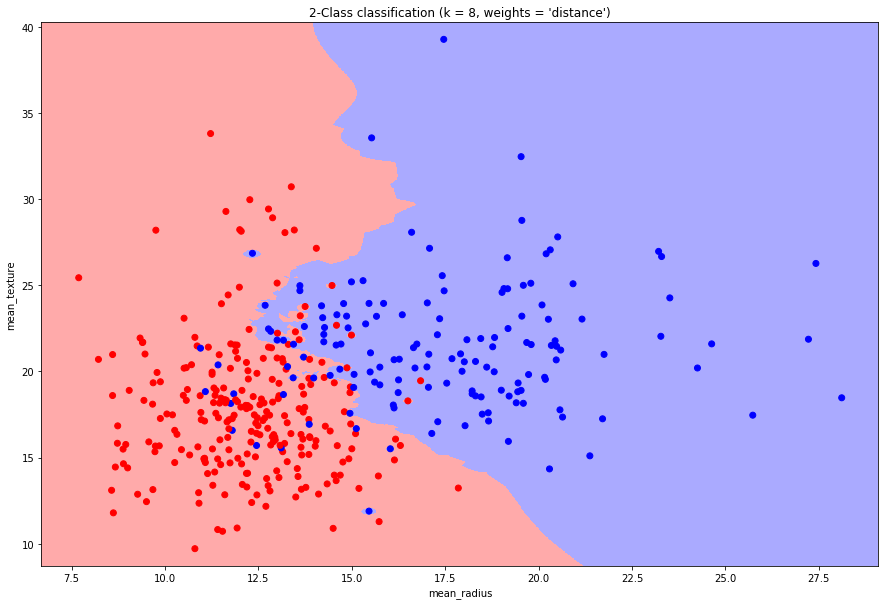

In [32]:
## Visualization of the decision boundaries for KNN

## Just get two features for visualizing the kNN - we'll bring them back to the model later
X_copy = X_train[:, 0:2]

h = .02  # step size in the mesh

## Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

## We create an instance of Neighbours Classifier with the best params
clf = neighbors.KNeighborsClassifier(**best_knn_params)

# We train again the model as we will use only two variables to visualize the decision boundaries
clf.fit(X_copy, y_train)

## Plot the decision boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

## Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(15, 10))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

## Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-Class classification (k = %i, weights = '%s')"
              % (best_knn_params['n_neighbors'], best_knn_params['weights']))

plt.xlabel(feature_names[featureA])
plt.ylabel(feature_names[featureB])

## Show the plot!
plt.show()

# The boundaries are quite - this model should generalize pretty well, and better than our DecisionTree model.  Out of the first two I have tested, I would select the kNN model, but I have one more to test.

# C. Logistic Regression Model

## In order to run the LR, we again need to NORMALIZE the feature of our data set.  If they do not look like a normal distribution of data (0 mean, 1 SD), the L1/L2 regularizers of linear models will not behave correctly.  This was an issue I ran into when first developing the LR model.

In [33]:
## Save a version of the standardized test data to a new variable so that we don't overwrite our existing training set
## I want to be able to replicate these results in future tests
X_train_lr = StandardScaler().fit_transform(X_train)

## Like in the kNN model selection, I am going to run a GridSearch object to run through the various parameters available to me in an LR model.  I will use my standarized training data to ensure good performance/behavior.

In [34]:
# Going to try two different LR models, one using L1 as the penalty
lr1 = linear_model.LogisticRegression()

param_grid = {"penalty": ['l1'],
              "solver": ["liblinear"],
              "C": np.logspace(-4, 4, 20),
              "random_state": [42],
              "multi_class": ['ovr', 'auto'],
              "max_iter": [4000]
             }

## Use gridsearch to test all values for n_neighbors, with 1000 fits.
lr1_gscv = GridSearchCV(lr1, param_grid, cv = 10)

## fit model to our training data
lr1_gscv.fit(X_train_lr, y_train)

C:\Python\envs\MSBA2020\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.000000...
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [4000], 'multi_class': ['ovr', 'auto'],
 

In [35]:
## Print out what the best LR score is based on the training data
print(lr1_gscv.best_params_)
print()

## Print out how well it performed using the best params
print(lr1_gscv.best_score_)

{'C': 1.623776739188721, 'max_iter': 4000, 'multi_class': 'ovr', 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}

0.9748743718592965


In [36]:
## Now I try using L2 as the penalty, I will need a different solver for this case
## I will also try a couple of different classes
## I keep the seed and C the same for consistency

lr2 = linear_model.LogisticRegression()

param_grid = {"penalty": ['l2'],
              "solver": ["newton-cg"],
              "C": np.logspace(-4, 4, 20),
              "random_state": [42],
              "multi_class": ['ovr', 'multinomial', 'auto'],
              "max_iter": [4000]
             }

## Use gridsearch to test all values for n_neighbors, with 1000 fits.
lr2_gscv = GridSearchCV(lr2, param_grid, cv = 10)

## fit model to our training data
lr2_gscv.fit(X_train_lr, y_train)

C:\Python\envs\MSBA2020\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.000000...
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [4000],
                         'multi_c

In [37]:
## Print out what the best neighbors score is based on the training data
print(lr2_gscv.best_params_)
print()

## Print out how well it performed using the best params
print(lr2_gscv.best_score_)

l2_params = lr2_gscv.best_params_

{'C': 0.615848211066026, 'max_iter': 4000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg'}

0.9773869346733668


# Pretty incredible precision from both Logistic Regression models, the second model only outperforms the first by .002%.... This is the one I will select.  Let's actually run them with the data to see.

In [38]:
## Create a new linear model with the best params that we received from testing above by unpacking them.
clf = linear_model.LogisticRegression(**l2_params)

## Train the model by fitting the normalized data
clf = clf.fit(X_train_lr, y_train)

# Evaluate performance
scores = cross_val_score(clf, X_train, y_train, cv=10)
print(scores)

[0.925      0.95       0.95       0.925      0.975      0.95
 1.         0.95       0.9        0.86842105]


In [39]:
# The mean score and the 95% confidence interval of the score estimate are hence given by:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.94 (+/- 0.07)


In [40]:
## Normalize our test data set - otherwise the predctions will be no good!
## Save a version of the standardized test data to a new variable so that we don't overwrite our existing training set
X_test_lr = StandardScaler().fit_transform(X_test)

In [41]:
## Build a confusion matrix from our Logistic Regression model - we want to see how accurate it is
predicted = clf.predict(X_test_lr)
matrix = confusion_matrix(y_test, predicted)
print(matrix)
print()

report = classification_report(y_test, predicted)
print(report)

[[108   0]
 [  3  60]]

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       108
           1       1.00      0.95      0.98        63

    accuracy                           0.98       171
   macro avg       0.99      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



# Our tuned Logistic Regression model performs extremely well!  It not only correctly identifies 97%(108/111) of Benign tumors and more importantly does not misclassify a single Malignant tumor.  This may be too good to be true so we will need to proceed with caution when using this model on a larger data set.

# As a final step in the analysis, let's visualize the decision boundaries of our Logistic Regression model using the first two features

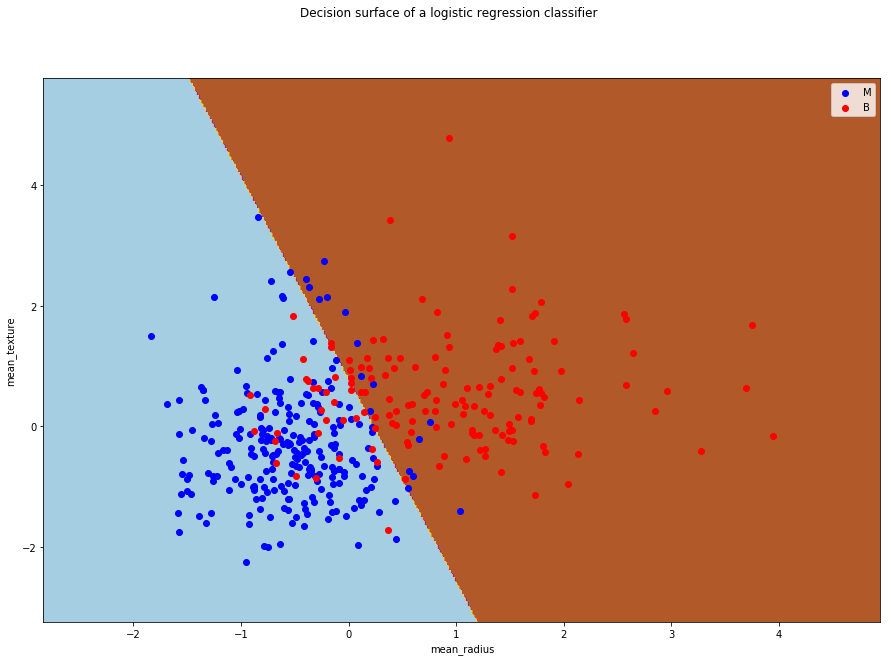

In [42]:
## Decision Boundary Visualization for Logistic Regression Model
# Plot the decision surface of the Logistic Regression classifier

plot_colors = "bry"
plot_step = 0.02

## Create a new figure with a bigger plot size to better see the data
fig = plt.figure(1, figsize=(15,10))

## Grab the feature names from the original df to display in the plot below
feature_names = wdbc.columns[2:-1]

featureA = 0
featureB = 1
X = X_train_lr[:, [featureA, featureB] ] # We only take the two corresponding features
y = y_train

n_classes = len(set(y))

# Train
clf = clf.fit(X, y) # we train again the model as we will use only two variables to visualize the decision boundaries

# Plot the decision boundary.  
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.xlabel(feature_names[featureA])
plt.ylabel(feature_names[featureB])
plt.axis("tight")

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                cmap=plt.cm.Paired)

plt.axis("tight")

plt.suptitle("Decision surface of a logistic regression classifier")
plt.legend()
plt.show()

# A very definitive line can be observed here.  We do see some pockets of data points that might get mislabeled but this data set is challenging with so many features to choose from.<br>

# Out of the three models, the Logistic Regression model performs the best when predicting the presence of malignant tumors.  However, I am cautious to proceed with using this model as it may be performing extremely well on the limited test data.<br>

# I am most comfortable using the kNN model for prediction, as it has a good accuracy/precision and f1 score when predicting Malignant tumors, and won't be as prone to overfitting as our LR or DecisionTree models.<br>


# Potential next steps:
## * Additional hyperparameter tuning might be helpful since our dataset is very limited.  
## * Run the models on a much larger data set to truly determine their performance.

# Thank you for reading my analysis!